## Autoencoder Convolucional SSA - Two layers HH

Continuamos el estudio de la aproximación SSA a primer orden. Entrenamos un modelo convolucional utilizando imágenes de gráficos polares de la sección eficaz en el canal HH - $\sigma_{HH}(\hat{k}_x, \hat{k}_y)$ -, generados por un modelo de dos capas rugosas bajo la aproximación SSA. 

### Generamos los datos


Usamos un modelo numérico para generar nuestros datos. 

In [22]:
import numpy as np

import two_rough_layers 

# Parámetros fijos
realizations = 20480

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/.245
d = np.linspace(.1, .7, 35)
ep1, ep2 = np.arange(3, 38), np.arange(3, 38)
s1, s2 = np.linspace(.004, .012, 35), np.linspace(.004, .012, 35)
l1, l2 = 6*s1, 6*s2
theta_i, phi_i = 38.5*np.pi/180, 0 

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 64)*np.pi / \
    180, np.linspace(0, 360, 64)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1]))


for i in range(realizations):
    # Genero una tira de indices aleatorios
    index = rng.integers(35, size=7)
    
    # Armo una tupla con los argumentos de S01     
    args = (k0, THETA, PHI,
            theta_i, phi_i, 
            ep1[index[0]], ep2[index[1]],
            s1[index[2]], l1[index[3]],
            s2[index[4]], l2[index[3]],
            d[index[6]])

    # Calculo la sección eficaz y agrego ruido
    s_O1 = two_rough_layers.suma_O1(*args)

    # h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh #+ np.abs(rng.normal(0, .03*np.std(s_hh), size=PHI.shape))

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))
    if cond == 0:
        sigma[i, :, :] = s_hh_noise
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')

# Chequeo el tamaño de los datos
shape = sigma.shape
print(f'Tamaños de los datos originales: {shape}')

Tamaños de los datos originales: (20480, 64, 64)


Guardamos los datos para re-usarlos más adelante

In [2]:
import os 

# Get data directory path
src_dir = os.path.normpath(os.getcwd() + '/../..')
data_dir = os.path.join(src_dir, 'data/ssa')

# Save Sigma in file
file_name = 'scatt_cross_section.npy'

In [ ]:
np.save(os.path.join(data_dir, file_name), sigma)

### Preparamos los datos

Comencemos separando los datos en conjuntos de entrenamiento y testeo. Apliquemos una estandarización de los datos, teniendo en cuenta el IQR.

In [3]:
# Cargamos los datos
import numpy as np
sigma = np.load(os.path.join(data_dir, file_name))

In [4]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.2)

print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (16384, 64, 64)
Tamaño de los datos de testeo: (4096, 64, 64)


Defino una clase que realiza el scaleo, así pueod usarla más adelante en un pipeline.

In [5]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin

class Scaler(RobustScaler):
    def __init__(self):
        super().__init__()

    def fit(self, X):
        return super().fit(X.reshape(-1, X.shape[-1]), y=None)
    
    def transform(self, X):
        X_shape = X.shape
        scaled = super().transform(X.reshape(-1, X_shape[-1]))
        return scaled.reshape(X_shape)

    def fit_transform(self, X, **fit_params):
        X_shape = X.shape
        transformed = super().fit_transform(X.reshape(-1, X_shape[-1]), y=None, **fit_params) 
        return transformed.reshape(X_shape)      

In [ ]:
# Fiteo con el conjunto de entrenamiento
scaler = Scaler().fit(sigma_train)

# Transformo ambos conjuntos
scaled_train = scaler.transform(sigma_train)
scaled_test = scaler.transform(sigma_test)

In [38]:
scaled_train, scaled_test = np.expand_dims(scaled_train, axis=-1), np.expand_dims(scaled_test, axis=-1)

print(f'Tamaño de los datos de entrenamiento: {scaled_train.shape}')
print(f'Tamaño de los datos de testeo: {scaled_test.shape}')

Tamaño de los datos de entrenamiento: (14336, 64, 64)
Tamaño de los datos de testeo: (6144, 64, 64, 1)


#### Visualizo las soluciones generadas

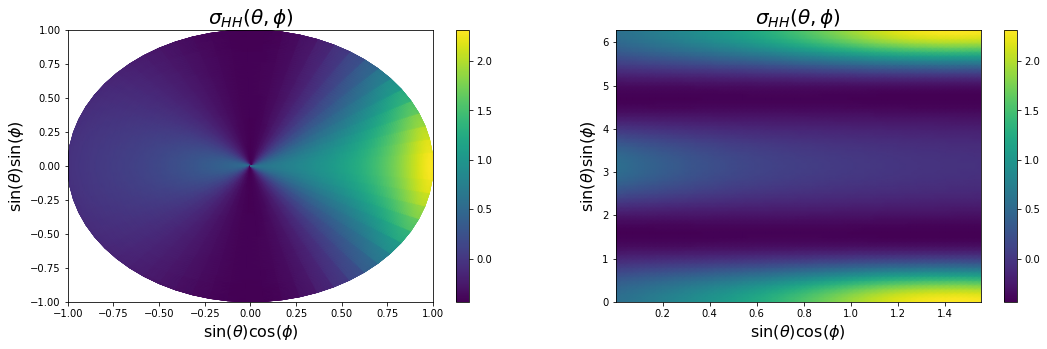

In [39]:
from matplotlib import pyplot as plt

# Elijo una imagen al azar
rng = np.random.default_rng()
index = rng.integers(scaled_train.shape[0]) 
img = scaled_train[index, :, :, 0]

# Dominios 
theta, phi = np.linspace(1e-5, 89, 64)*np.pi / \
    180, np.linspace(0, 360, 64)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

fig = plt.figure(figsize=(18, 5))

# Canal HH
ax = plt.subplot(1, 2, 1)
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 2, 2)
c = ax.pcolormesh(THETA, PHI, img,
                  shading = 'gouraud')
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


### Definimos el modelo de aprendizaje profundo: Autoencoder Convolucional

Defino un modelo que voy a ir retocando para llegar a que *pueda aprender* los datos generados. Una vez que consiga esto, pasamos a ajustar hyperparámetros.

In [6]:
import tensorflow as tf

# Config tf verbosesity 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check GPU's 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim, kernel_init='glorot_uniform'):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (64, 64, 1)), 
                                            layers.Conv2D(4, (6, 6), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(16, (5, 5), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(32, (4, 4), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),

                                            layers.Conv2D(32, (3, 3), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),

                                            layers.Flatten(),
                                            
                                            layers.Dense(units=6*6*32, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),

                                            layers.Dense(units=256, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Dense(units=128, activation='relu', kernel_initializer=kernel_init), 

                                            layers.Dense(units=64, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            #layers.Dropout(.2),

                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

                                            layers.Dense(units=64, activation='relu', kernel_initializer=kernel_init), 
                                            #layers.Dropout(.2),

                                            layers.Dense(units=128, activation='relu', kernel_initializer=kernel_init), 

                                            layers.Dense(units=256, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),                                          

                                            layers.Dense(units=6*6*32, activation='relu', kernel_initializer=kernel_init), 
                                            #kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                                            layers.Dropout(.2),
                                            
                                            layers.Reshape(target_shape=(6,6,32)),
                                            
                                            layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu"),

                                            layers.Conv2DTranspose(32, (4, 4), strides=2, activation="relu"),
                                            
                                            layers.Conv2DTranspose(16, (5, 5), strides=2, activation="relu"),

                                            layers.Conv2DTranspose(4, (6, 6), strides=1, activation='relu'),

                                            layers.Conv2D(1, (3, 3), activation="linear", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

    # def fit(self, X, **kwargs):
    #     return super().fit(X, X, **kwargs)    

In [115]:
tf.keras.backend.clear_session()
del autoencoder

# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [56]:
autoencoder = ConvAutoencoder(12)
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 59, 4)         148       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1616      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0

In [57]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                832       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1152)              296064    
                                                                 
 dropout_3 (Dropout)         (None, 1152)              0         
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)         

### Entrenamos nuestro Conv-Autoencoder

Defino Callbacks para reducir el learning rate y cortar el entrenamiento si no mejora.

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.15,
    patience=50,
    verbose=0,
    mode="min",
    min_delta=0.3,
    cooldown=0,
    min_lr=0.00001,
)

early_stopping = EarlyStopping(
    monitor='loss', 
    patience=75, 
    mode='min', 
    min_delta=0.1,
    restore_best_weights=True
    )

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

Generemos un optimizador con decay rate

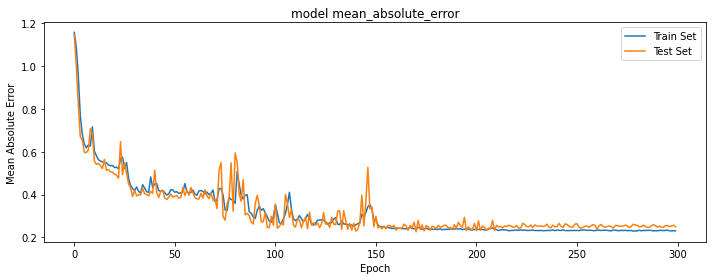

In [59]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = autoencoder.fit(
    scaled_train, 
    scaled_train,
    epochs = 300,
    batch_size = 1024,
    verbose = 0,
    validation_data=(scaled_test, scaled_test),
    callbacks=[reduce_lr]
    )

# Visualizo el entrenamiento
plt.figure(figsize = (10, 4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()


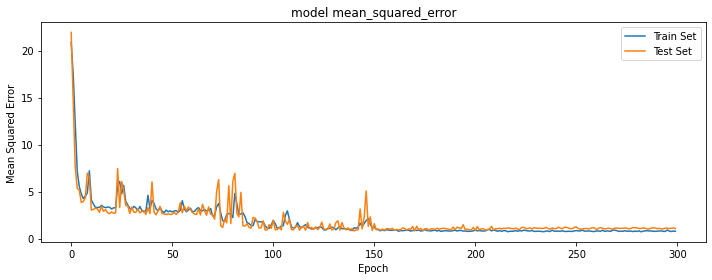

In [60]:
# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()

In [61]:
print(np.mean(history.history['mean_squared_error'][:200])-np.mean(history.history['mean_squared_error'][:150]))
print(history.history['mean_squared_error'][290])

-0.4941591614484788
0.7939457893371582


In [9]:
# Guardamos los pesos de la red entrenada
import os
file_name = 'results/weights_lat_3_ssa_two_layer_HH.h5'
folder = os.getcwd().split('/')[:-2]
weights_path = os.path.join('/'.join(folder), file_name)
autoencoder.save_weights(weights_path)

#### Visualizamos los resultados

Veamos cómo son las imágenes generadas por nuestro modelo

In [122]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(scaled_train[:1000]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

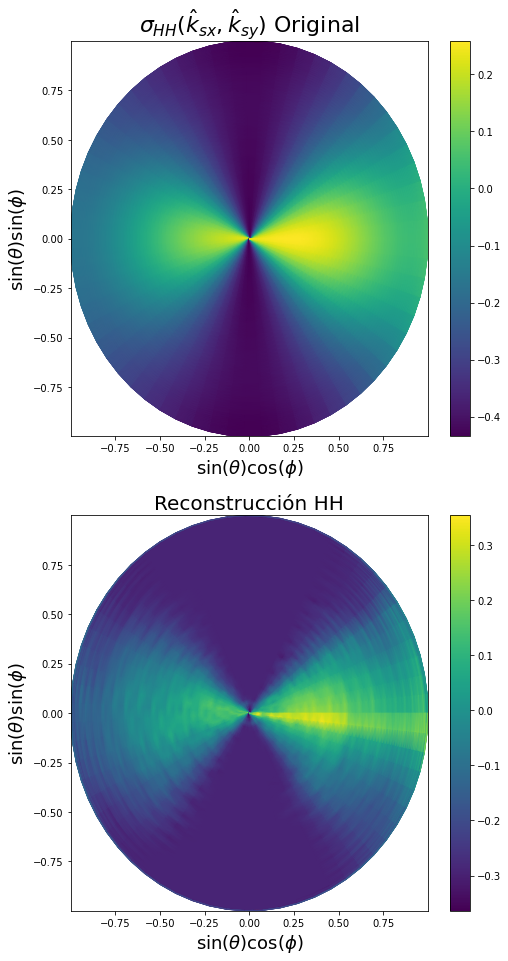

In [125]:
n = 1
pol = {0: "HH", 1: "HV", 2: "VV"}
index = rng.integers(encoded_imgs.shape[0])

fig = plt.figure(figsize=(8, 16)) 
for i in range(n):
    # Imagen original
    s = scaled_train[index, :, :, 0]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, 0]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()


### Ajuste de hyperparámetros

Vamos a buscar el optimizador, learning rate, inicializador de pesos y batch size optimos de nuestro modelo. Para eso vamos a usar Cross Validation junto con Grid Seach. Usamos GridSearchCV de Sklearn, junto con un wrapper de keras para nuestor modelo: KerasRegresor

In [41]:
from tensorflow.keras import optimizers as opt
from tensorflow.keras.losses import MeanSquaredError

from keras.wrappers.scikit_learn import KerasRegressor

def create_autoencoder(optimizer='adam',
                       learning_rate=0.0001,
                       beta_momentum=.9,
                       init='glorot_uniform'):
    tf.random.set_seed(123)                   

    # Create optimazer
    select_optimizer = {
        'adam': opt.Adam(learning_rate=learning_rate, beta_1=beta_momentum),
        'RMSProp': opt.RMSprop(learning_rate=learning_rate),
        'sgd': opt.SGD(learning_rate=learning_rate)
                        }
    gradient_descent = select_optimizer.get(optimizer, 'adam')

    # Create and Compile Model
    model = ConvAutoencoder(12, kernel_init=init)
    model.compile(
        optimizer=gradient_descent,
        loss=MeanSquaredError(),
        metrics=['mean_squared_error', 'mean_absolute_error']
        )

    return model

Genero un wrap para usar objetos de keras en scikitlearn

In [96]:
sckit_model = KerasRegressor(
    create_autoencoder, 
    verbose=0, 
    epochs=100, 
    #callbacks=[early_stopping]
    )

Genero un pipeline con la estandarización utilizada y el modelo de keras

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

pipeline = Pipeline(steps=[
    ('scaler' , Scaler()),
    ('add_xis', FunctionTransformer(np.expand_dims, kw_args={'axis':-1})),
    ('model', sckit_model)
    ])

Hacemos un Cross Validation sampleando aleatoriamente en la grilla de hyperpárametros.

In [92]:
from sklearn.model_selection import RandomizedSearchCV

l_rate = [0.00005, 0.0001, 0.0005, 0.001, 0.003]
kernel_init = ['glorot_uniform', 'lecun_uniform', 'normal']
batch = [32, 64, 256, 512, 1024]
grad_optimizer = ['adam', 'RMSProp', 'sgd']

hyperparam_grid = {'model__optimizer': grad_optimizer,
                   'model__learning_rate': l_rate,
                   'model__init': kernel_init,
                   'model__batch_size': batch}

cv = RandomizedSearchCV(pipeline, 
                        hyperparam_grid,
                        cv=5, 
                        n_iter=25, 
                        random_state=1, 
                        verbose=0,
                        scoring='neg_mean_squared_error' 
                        )


Fiteamos el modelo para cada hyperparametro sampleado. Para eso armamos un Pipeline en donde estandarizamos los datos y fiteamos para cada train set dentro del kfold. 

In [ ]:
tuned_model = cv.fit(sigma_train[:30], sigma_train[:30])

In [ ]:
# print results
print(f'Best Score for {tuned_model.best_score_:.4} using {tuned_model.best_params_}')
means = tuned_model.cv_results_['mean_test_score']
stds = tuned_model.cv_results_['std_test_score']
params = tuned_model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Score for -353.1 using {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 32}
mean=-353.1, std=89.91 using {'optimizer': 'adam', 'learning_rate': 0.001, 'init': 'normal', 'batch_size': 32}
mean=-369.1, std=94.38 using {'optimizer': 'RMSProp', 'learning_rate': 5e-05, 'init': 'normal', 'batch_size': 512}
mean=-365.9, std=92.66 using {'optimizer': 'adam', 'learning_rate': 0.0001, 'init': 'glorot_uniform', 'batch_size': 256}
mean=-369.0, std=94.39 using {'optimizer': 'sgd', 'learning_rate': 5e-05, 'init': 'lecun_uniform', 'batch_size': 64}


Lamentablemente no podemos usar un pipeline para hacer nuestro cv. Hay conflictos con que en nuestro caso X=sigma e y=sigma. Solo se scalea X -además agrega un eje-, mientras que y queda igual. Además, el fit de keras regresor también nos limita con la cantidad de axis de y.

Hagamos cv "a mano" con KFold, de paso podemos estar seguro que luego de cada iteración se sobreescribe el modelo haciendo un keras.backend.clear_session().

In [57]:
from sklearn.model_selection import KFold
from itertools import islice, product
import random

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Hyperparameter Space
l_rate = [0.00005, 0.0001, 0.0005, 0.001, 0.003]
kernel_init = ['glorot_uniform', 'lecun_uniform', 'normal']
batch = [32, 64, 256, 512, 1024]
grad_optimizer = ['adam', 'RMSProp', 'sgd']

space_grid = {
    'optimizer': grad_optimizer,
    'learning_rate': l_rate,
    'init': kernel_init,
    'batch_size': batch
                   }
# N samples for randomized search                   
n_samples = 25

# Form a list of hyperparameters values
hyperparameters_list = list(space_grid.values())

# Get all posible combinations of parameters
all_combinations = []
for items in product(*hyperparameters_list):
    all_combinations.append(dict(zip(space_grid.keys(), items)))

# Sample n_samples randomly from all combinations
rng = np.random.default_rng(123)
sampled_hyperparams = rng.choice(all_combinations, n_samples)

# Add default configuration
sampled_hyperparams = np.append(
    sampled_hyperparams, 
    {
        'optimizer': 'Adam', 
        'learning_rate': 0.0001, 
        'init': 'glorot_uniform', 
        'batch_size': 1024
        }
        )

# Variate all over samples 
configurations_score = []
best_score = 1e4
for params in sampled_hyperparams:

    # K-Fold cross validation with each hyperparam combination
    cv = KFold(n_splits=5)

    # Initialize list to save scores
    fold_score = []

    for train_index, test_index in cv.split(sigma_train[:7000]):
        # Split into train and test
        S_train, S_test = sigma_train[train_index], sigma_train[test_index]
        
        # Scale each set
        scaler = Scaler().fit(S_train)
        scaled_train = scaler.transform(S_train)
        scaled_test = scaler.transform(S_test)

        # Add extra dimension for ConvAE input
        scaled_train = np.expand_dims(scaled_train, axis=-1)
        scaled_test =  np.expand_dims(scaled_test, axis=-1)

        # Generate Model wrapper and compile it
        conv_ae = KerasRegressor(
            create_autoencoder,
            **params,
            nb_epoch=150,
            verbose=0
        )
        history = conv_ae.fit(scaled_train, scaled_train)

        # Calculate score
        score = history.history['mean_squared_error'][-30:]
        fold_score.append(np.mean(score))

        # Clear Tensorflow graph
        tf.keras.backend.clear_session()
        del conv_ae 

    run_data = {'params' : params, 'score': np.mean(fold_score)}
    configurations_score.append(run_data)
        
    if run_data['score'] < best_score:
        best_configuration = run_data          

    print(f'Parameters Configuration: {params}, score: {np.mean(fold_score)}')    

Parameters Configuration: {'optimizer': 'adam', 'learning_rate': 5e-05, 'init': 'glorot_uniform', 'batch_size': 512}, score: 22.58701820373535
Parameters Configuration: {'optimizer': 'sgd', 'learning_rate': 5e-05, 'init': 'glorot_uniform', 'batch_size': 512}, score: 22.58731346130371
Parameters Configuration: {'optimizer': 'Adam', 'learning_rate': 0.0001, 'init': 'glorot_uniform', 'batch_size': 1024}, score: 22.5640869140625


In [40]:
params = {'optimizer' : 'adam',
            }

def create_model(optimizer='adam'):
    model = tf.keras.Sequential([tf.keras.layers.Dense(units=10)])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


def create_autoencoder(optimizer='adam',
                       learning_rate=0.0001,
                       init='glorot_uniform'):
    tf.random.set_seed(123)                   

    # Create optimazer
    select_optimizer = {
        'adam': opt.Adam(learning_rate=learning_rate),
        'RMSProp': opt.RMSprop(learning_rate=learning_rate),
        'sgd': opt.SGD(learning_rate=learning_rate)
                        }
    gradient_descent = select_optimizer.get(optimizer, 'adam')

    # Create and Compile Model
    model = ConvAutoencoder(12, kernel_init=init)
    model.compile(
        optimizer=gradient_descent,
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'mean_absolute_error']
        )

    return model

print(params)
model = KerasRegressor(create_autoencoder, **params)
model.fit(
    scaled_train,
    scaled_train
    )

{'optimizer': 'adam'}


/tmp/ipykernel_6651/497877536.py:34: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(create_autoencoder, **params)


410/410 [==============================] - 15s 30ms/step - loss: 10.4293 - mean_squared_error: 10.4293 - mean_absolute_error: 0.8944


Generemos un optimizador con decay rate

In [53]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay, PiecewiseConstantDecay

# Define size of mini batch and training epochs
epochs = 300
batch_size = 1024

# Learning rate decay and steps
initial_learning_rate = 0.0008
final_learning_rate = 0.00005
decay_rate = (initial_learning_rate - final_learning_rate)/epochs
decay_steps = int(scaled_train.shape[0] / batch_size) 
total_steps = decay_steps*epochs

# Learning rate schedule
polynomial_learning_rate = PolynomialDecay(
    initial_learning_rate, 
    decay_steps=total_steps, 
    end_learning_rate=final_learning_rate, 
    power=3,  
    name=None
)

step_learning_rate = PiecewiseConstantDecay(
    boundaries=[bound for bound in range(2000, 16000, 2000)],
    values=[0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00008, 0.00005, 0.00001]
)

# opt=tf.keras.optimizers.SGD(
#     learning_rate=.4, decay=decay_rate, momentum=0.99, nesterov=False, name="SGD", 
#     clipnorm=1)

# Gradient descent optimizer
opt = tf.keras.optimizers.Adam(
    learning_rate=polynomial_learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


Veamos la pinta del learning rate para cada epoch

In [ ]:
total_steps = decay_steps*epochs
decay = [polynomial_learning_rate(step) for step in range(1, total_steps + 1)]

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
plt.plot(range(1, total_steps + 1), decay)
ax.set_xlabel('Step')
ax.set_ylabel('Inverse Decay')
ax.set_title('Learning rate decay during training')

### Pruebo con KFold Cross Validation


In [ ]:
from sklearn.model_selection import KFold

def log_mapping(tensor):
    """Mapea la distribución de los datos
    a una distribución uniforme"""
    
    # Hago un primer reescaleado
    scaled_tensor = MinMax(tensor)

    # Paso a una escala en DB
    scaled_tensor = np.where(scaled_tensor!=0.0, scaled_tensor, 1e-7)

    return MinMax(10*np.log10(scaled_tensor))

kfold_cv = KFold(n_splits=5)
mse = list()
mae = list()

for train_fold, test_fold in kfold_cv.split(sigma):
    # Transformo los datos
    sigma_train = log_mapping(sigma[train_fold, :, :])
    sigma_test = log_mapping(sigma[test_fold, :, :])

    # Agrego una dimensión más para ingresar a la red
    sigma_train = np.expand_dims(sigma_train, axis=-1)
    sigma_test = np.expand_dims(sigma_test, axis=-1)
    
    # Entreno el modelo
    autoencoder = ConvAutoencoder(8)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
                    
    history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 100,
            batch_size = 32,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

    # Guardo los datos 
    mse.append((history.history['mean_absolute_error'],
                history.history['val_mean_absolute_error']))
    mae.append((history.history['mean_squared_error'], 
                history.history['val_mean_squared_error']))
     
    # Elimino el modelo de memoria
    tf.keras.backend.clear_session()
    del autoencoder      

mse = np.vstack(mse)
mae = np.vstack(mae)      

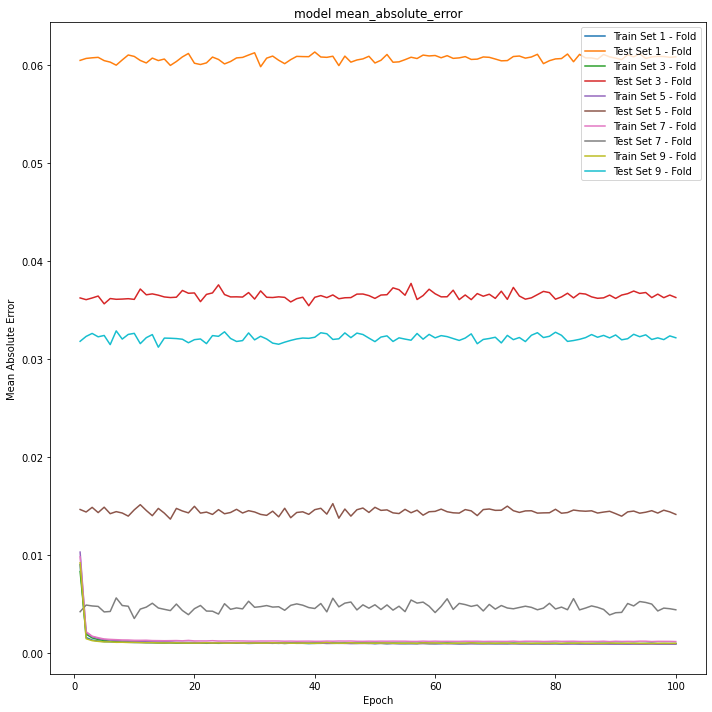

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for idx, error in enumerate(mse):
    f,  = ax.plot(range(1, 101), error)
    if idx%2==0:
        f.set_label(f'Train Set {idx + 1} - Fold')
    else: 
        f.set_label(f'Test Set {idx} - Fold')
    ax.set_title('model mean_absolute_error')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Epoch')
plt.legend()    
plt.tight_layout()    
plt.show()

## Variamos la dimensión del Espacio Latente

In [77]:
# Antes de comenzar limpiamos los pesos del modelo y el grafo de TF
tf.keras.backend.clear_session()
del autoencoder

In [16]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = ConvAutoencoder(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 30,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 10 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  tf.keras.backend.clear_session()

In [27]:
error_abs = np.array(history.history['val_mean_absolute_error'])
error_sqr = np.array(history.history['val_mean_squared_error'])

# Valor mínimo del error
min_abs_error[13] = error_abs.min()
min_sqr_error[13] = error_sqr.min()

# Valor promedio del error en los ultimos 10 epochs
avg_abs_error[13] = np.mean(error_abs[-50:])
avg_sqr_error[13] = np.mean(error_sqr[-50:])

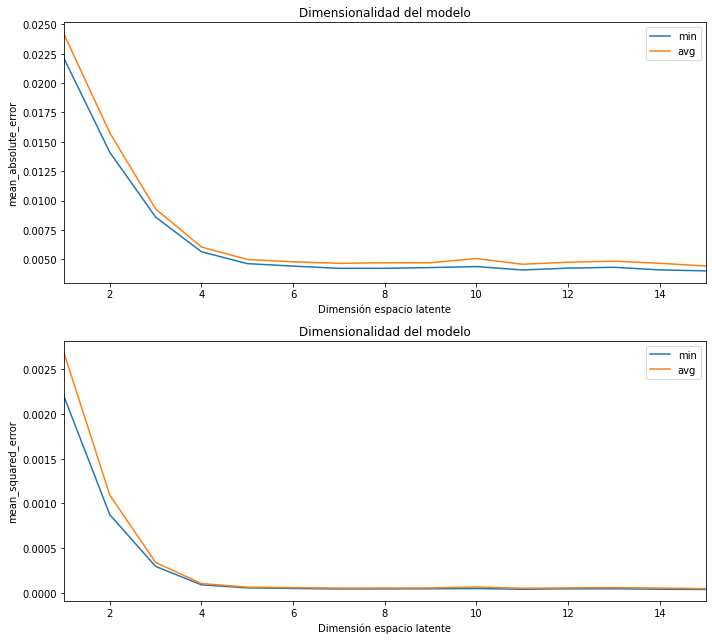

In [28]:
img_name= 'results/costo_SSA_two_layer_2_HH_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [29]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SSA_two_layer_HH.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)